## Camera calibration
**pyorc** is equipped with a very straightforward manner to calibrate your camera lens. The process is as follows:

* Take a video with a chessboard pattern ensuring you maximize difference in location in the FOV where the chessboard is shown, and the different rotation angles under which the chessboard is shown. Ensure that the video is taken with the *exact same settings* as you expect to use in the field.
* Start with a fresh camera configuration, ensuring height and width follow the settings of your intended video resolution
* Feed in the calibration video. This will extract a set amount of frames with recognised chessboard patterns widely sampled over the entire video, calibrate the intrinsic matrix and distortion coefficients, and overwrite these in the camera configuration.

In this notebook we will demonstrate this entire process. It should be noted that if your lens only has very little distortion, this process is likely not needed and may in fact even deteriorate your results.

In [1]:
import copy
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pyorc

In [6]:
vid.end_frame

352

We pretend that we are going to treat videos of 720p resolution (height: 720, width: 1280). A sample video is included in the repository. Let's first have a look at the first frame of this video.

/home/cemmi/anaconda3/envs/river_flow/lib/python3.9/site-packages/pyorc/api/video.py:121: UserWarning: End frame 401 cannot be read from file. End frame is adapted to 352
  warnings.warn(f"End frame {end_frame} cannot be read from file. End frame is adapted to {frame_number[-1]}")


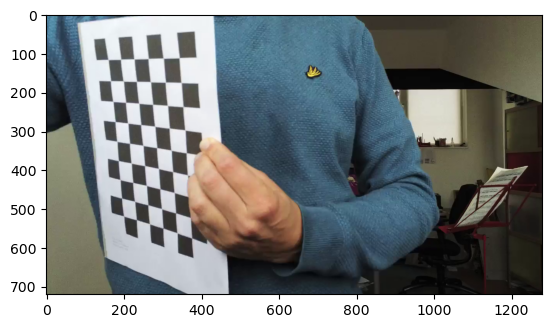

In [2]:
fn = "camera_calib/camera_calib_720p.mkv"
vid = pyorc.Video(fn)
frame = vid.get_frame(0, method="rgb")
plt.imshow(frame)

The algorithm uses automatic detection of chessboard corners. It only detects chessboard corners *within* the image, so not at the edge. Hence, this is a 9x6 pattern, which is the default setting. Let's now first make a default camera configuration, without the camera calibration applied.

In [3]:
cam_config = pyorc.CameraConfig(height=720, width=1280)
cam_config


{
    "height": 720,
    "width": 1280,
    "resolution": 0.05,
    "lens_position": null,
    "window_size": 10,
    "is_nadir": false,
    "dist_coeffs": [
        [
            0.0
        ],
        [
            0.0
        ],
        [
            0.0
        ],
        [
            0.0
        ]
    ],
    "camera_matrix": [
        [
            1280.0,
            0.0,
            640.0
        ],
        [
            0.0,
            1280.0,
            360.0
        ],
        [
            0.0,
            0.0,
            1.0
        ]
    ]
}

### using the wrong chessboard pattern
You can see the camera matrix above looks quite like a default, and distortion coefficients are all zero. Let's now do a calibration. Let us first have a look what happens if the wrong chessboard pattern is passed. We assume the user thought that the outer edges should also be included. That would mean the user would apply a 11x8 pattern. To ensure we are not searching for a very long time, we limit the amount of frames to 50.

In [7]:
cam_config.set_lens_calibration(fn, chessboard_size=(9, 6), frame_limit=50)

 76%|█████████████████████████████████████████████████████████████████████████████████████████▋                            | 38/50 [00:16<00:05,  2.30it/s]

Maximum required images 30 found


Average error on point reconstruction is 0.0886404482602786


That gave an error, let's now do it the right way. We use the right chessboard size. While executing this, you may comment the first line (setting `plot=True`) and uncomment the second to see a regularly updated pop up with visual feedback. In the process we also set `to_file=True`. This causes the algorithm to also write .png files of the found frames and the found corner points. These files are always found side-by-side with the provided video. 

In [8]:
cam_config.set_lens_calibration(fn, chessboard_size=(9, 6), plot=False, to_file=True)
# cam_config.set_lens_calibration(fn, chessboard_size=(9, 6), plot=True, to_file=True)

  9%|███████████                                                                                                          | 38/401 [00:01<00:17, 21.16it/s]


Maximum required images 30 found
Average error on point reconstruction is 0.0886404482602786


So what happened? The algorithm siffs through all frames in such a way that all parts of the video are very well covered (i.e. not in the order in which the frames are stored). It start with the first and last frame. Then samples the frame in the middle. Then in between the first and middle, and middle and last, and so forth. In this way we ensure that all poses shown are well sampled and that we do not end up with many samples that show almost the same pose, causing overfitting of the parameters on just one pose (which may in fact give very very bad results, rendering camera calibration a bad thing rather than a good thing. The algorithm stops searching for corner points once `max_frames` is reached, which defaults to 30. The progress bar therefore does not reach 100%, because that would mean all frames in the video are read. The error is a measure for the average pixel error made when projecting the found corner points back to the image using the calibrated parameters. Let's check what the intrinsic matrix and distortion coefficients look like.

In [9]:
print(f"Camera Matrix: {cam_config.camera_matrix}")
print(f"Distortion coefficients: {cam_config.dist_coeffs}")

Camera Matrix: [[944.3875397993983, 0.0, 632.7985938321381], [0.0, 943.89432296674, 333.37555176671424], [0.0, 0.0, 1.0]]
Distortion coefficients: [[0.042311340463484746, -0.1481871927123828, -0.007924199637040144, 0.0005261762355578921, 0.34505366854630126]]


They are now clearly different from the default. We can also plot the images, written to disk to verify if we are happy with the found coverage of poses. If a large part of the VOF or rotations is missing, we can still extend the amount of frames

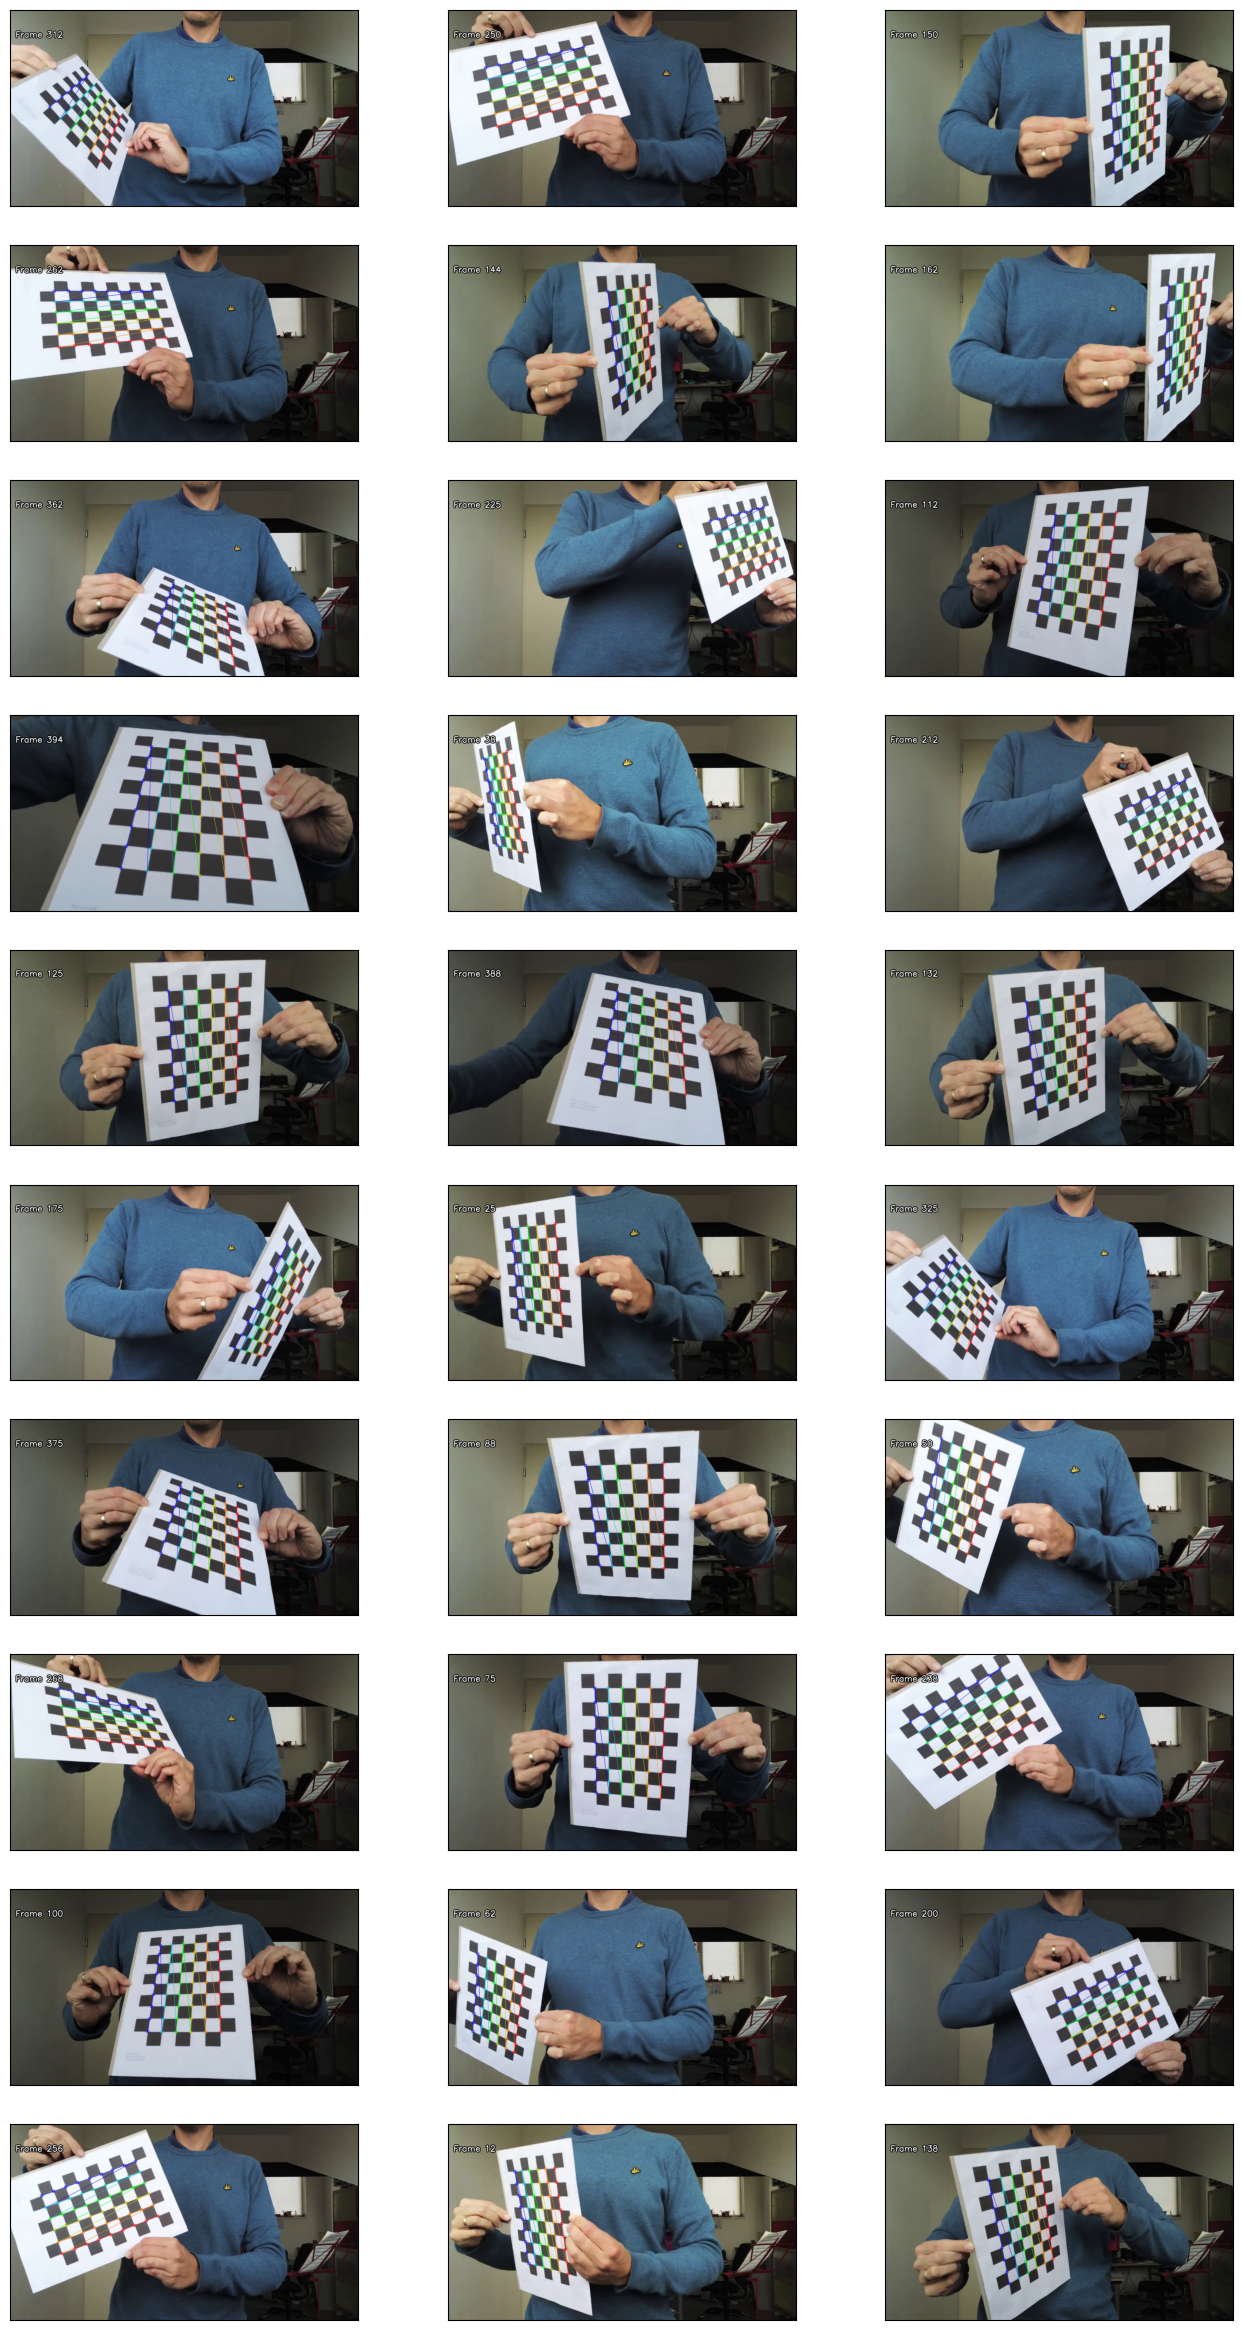

In [10]:
paths = glob.glob(os.path.join("camera_calib", "*.png"))

# plot all results in 3 columns
cols = 3
rows = int(np.ceil(len(paths)/cols))
rows, cols
f = plt.figure(figsize=(16, 3*rows))
for n, fn in enumerate(paths):
    ax = plt.subplot(rows, cols, n + 1)
    img = cv2.imread(fn)
    # switch colors
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.tick_params(
        left=False,
        right=False,
        labelleft=False,
        labelbottom=False,
        bottom=False,
    )


### Result of undistortion
Below we will have a look what the undistortion process does with the resulting frames. The plot of the difference reveals that in the middle, distortions were very small, while at the edges, distortions are larger. The image is somewhat stretched at the edges. This is nicely corrected for with our calibration. All extracted frames and the `src` point locations are automatically undistorted while transforming a video into frames and performing orthorectifaction.

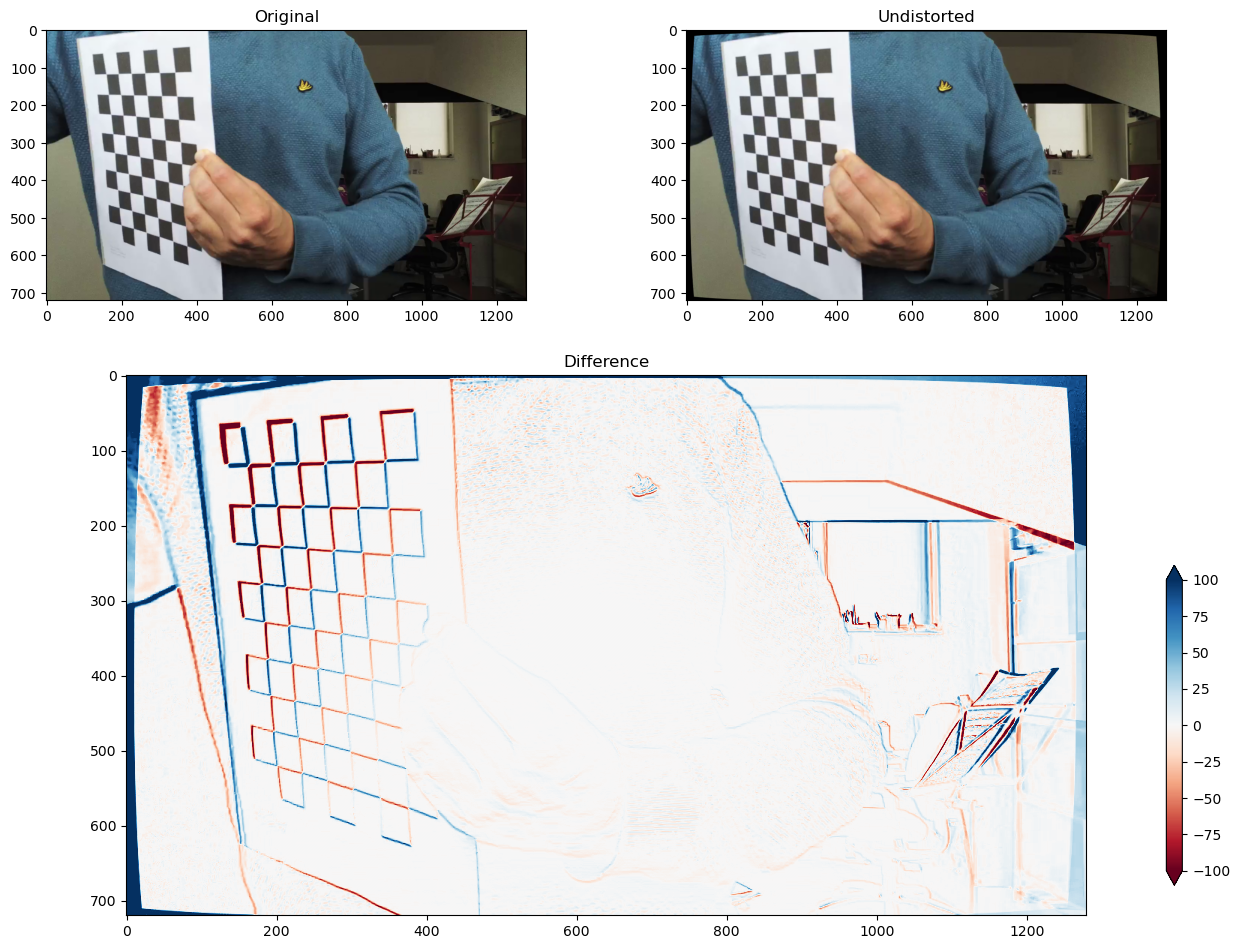

In [11]:
import cv2
import matplotlib.pyplot as plt
fn = "camera_calib/camera_calib_720p.mkv"

# open without camera configuration
vid = pyorc.Video(fn)
frame = vid.get_frame(0, method="rgb")

# open the video once more
vid_undistort = pyorc.Video(fn, camera_config=cam_config)
# extract the first frame once more
frame_undistort = vid_undistort.get_frame(0, method="rgb")
diff = np.mean(np.int16(frame) - np.int16(frame_undistort), axis=-1)

f = plt.figure(figsize=(16, 16))
ax1 = plt.axes([0.05, 0.45, 0.3, 0.2])
ax2 = plt.axes([0.45, 0.45, 0.3, 0.2])
ax3 = plt.axes([0.1, 0.05, 0.6, 0.4])
cax = plt.axes([0.75, 0.1, 0.01, 0.2])
ax1.set_title("Original")
ax2.set_title("Undistorted")
ax3.set_title("Difference")
ax1.imshow(frame)
ax2.imshow(frame_undistort)

# make some modern art for the difference
p = ax3.imshow(diff, cmap="RdBu", vmin=-100, vmax=100)
plt.colorbar(p, cax=cax, extend="both")

